> Tip: This is the exercise I selected to solve, resnet18 transfer learning for flowers 102 dataset, but I also submit the [NLP soltion here](https://github.com/tyoc213/blog/blob/master/__explorations__/2020_53/fasthugs_yelp_5.ipynb) which was different to what I learned in fastai course 

# Description

> Use the Flowers dataset and a pretrained ResNet 18 to demonstrate why initial layers are frozen during the first few epochs of transfer learning. Does your model do better or worse when you freeze the initial layers for the first few epochs?

## flowers

* main http://www.robots.ox.ac.uk/~vgg/data/flowers/102/
* tutorial None
* download 	https://s3.amazonaws.com/fast-ai-imageclas/oxford-102-flowers.tgz
* SOTA https://paperswithcode.com/sota/fine-grained-image-classification-on-oxford

## Resnet 18

* main https://pytorch.org/docs/stable/torchvision/models.html#torchvision.models.resnet18
* tutorial https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

The SOTA for this dataset is pretty high more than 99% as taked from https://paperswithcode.com/sota/image-classification-on-flowers-102 but none of them is with resnet18.

We know there are 102 classes to classify, we can visualize a sample with `show_batch` and we can peek at data with pandas and see what is inside.

It would be helpfull to use augmentation transforms for computer vision problems that come with fastai, most probably will help our training.

I also check the tutorial on how to do it with pytorch which I know as a base component for fastai, and see its transfer learning result which indeed uses augmentation transforms too for its training.

I think the model itself could not be improved more in the sense that is a well know model, but the data can be manipulated more, finding correct learning rates and batch sizes would help too, and maybe doing some other kind of image manipulations like the ones used on contrastive learning that goes with gamma and so on, mixup and maybe others.

This exercise have helped me to look more closely at freezing and unfrezing layers and in general to transfer learning and manipulating directly some layers.

# Setup

First install fastai and get the data to default fastai directory.

In [1]:
!pip freeze | grep fastai | wc -l | grep -w "0" && pip install fastai

In [2]:
from fastai.vision.all import *

/home/tyoc213/Documents/github/fastai/fastai/callback/hook.py:190: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if np is not '':


In [3]:
path=untar_data('https://s3.amazonaws.com/fast-ai-imageclas/oxford-102-flowers.tgz')

Now we can take a look at what is inside the folder and do other walks on the dir data

In [4]:
path.ls()

(#7) [Path('/home/tyoc213/.fastai/data/oxford-102-flowers/test.txt'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/val'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/models'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/train'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/train.txt'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/valid.txt')]

After carefull ookup at the structure and content les extract the paths for elements 0, 2 and 3  which are

In [5]:
p0,p2,p3 = path/'test.txt', path/'train.txt', path/'valid.txt'
!echo "test" && tail $p0 && cat $p0 | wc -l
!echo "train" && tail $p2 && cat $p2 | wc -l
!echo "valid" && tail $p3 && cat $p3 | wc -l
(path/'jpg').ls()

test
jpg/image_00985.jpg 45
jpg/image_06412.jpg 8
jpg/image_07145.jpg 44
jpg/image_00638.jpg 88
jpg/image_07558.jpg 94
jpg/image_08168.jpg 61
jpg/image_07487.jpg 94
jpg/image_04432.jpg 89
jpg/image_02532.jpg 75
jpg/image_00178.jpg 76
6149
train
jpg/image_04045.jpg 11
jpg/image_06142.jpg 63
jpg/image_07082.jpg 66
jpg/image_03345.jpg 7
jpg/image_07587.jpg 94
jpg/image_02944.jpg 59
jpg/image_07434.jpg 93
jpg/image_02684.jpg 57
jpg/image_01639.jpg 81
jpg/image_03165.jpg 10
1020
valid
jpg/image_05678.jpg 3
jpg/image_06638.jpg 2
jpg/image_05185.jpg 4
jpg/image_00516.jpg 87
jpg/image_04516.jpg 70
jpg/image_08182.jpg 61
jpg/image_07029.jpg 38
jpg/image_05956.jpg 67
jpg/image_06051.jpg 13
jpg/image_07724.jpg 96
1020


(#8189) [Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_04376.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_01488.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_01097.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_07466.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_06858.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_05681.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_07165.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_05913.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_02539.jpg'),Path('/home/tyoc213/.fastai/data/oxford-102-flowers/jpg/image_07056.jpg')...]

Now we can create our dataset to train our model mixing train and valid sets

In [6]:
df_train = pd.read_csv(path/'train.txt', header=0,sep=" ", names=['img', 'label'])
df_train['is_valid'] = False
df_valid = pd.read_csv(path/'valid.txt', header=0,sep=" ", names=['img', 'label'])
df_valid['is_valid'] = True
df = pd.concat([df_train, df_valid])
df.head(), df.tail()

(                   img  label  is_valid
 0  jpg/image_06092.jpg     13     False
 1  jpg/image_02400.jpg     42     False
 2  jpg/image_02852.jpg     55     False
 3  jpg/image_07710.jpg     96     False
 4  jpg/image_07191.jpg      5     False,
                       img  label  is_valid
 1014  jpg/image_08182.jpg     61      True
 1015  jpg/image_07029.jpg     38      True
 1016  jpg/image_05956.jpg     67      True
 1017  jpg/image_06051.jpg     13      True
 1018  jpg/image_07724.jpg     96      True)

And load directly into a `DataLoader` with `ImageDataLoaders.from_df`

In [7]:
dls = ImageDataLoaders.from_df(df, path, valid_col='is_valid',
                               bs=64,
                               item_tfms=Resize(320)
                              )

## visualizing a subsample of data

We can use `show_batch` to show up to `max_n` different images each time we call it, so we can see diferent samples of the photos, see that all of them are now 320px in size.

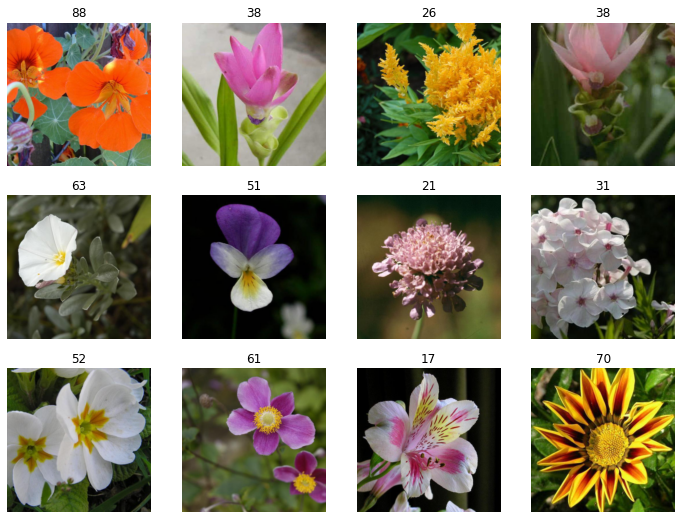

In [8]:
dls.show_batch(max_n=12)

## extra setup

We can define a `MODELO` variable to change easely the type of pretrained model we want to test, also we use `MIN_EPOCHS` to have a base of how many epochs we want defined in "some place".

To see the change in the trainable parameters, I use `layer_info` of fastai to get the total count of total parameters and which of them are trainable, using `@patch_to` I add it to the `Learner` class.

In [9]:
MODELO=resnet18
MIN_EPOCHS=3

@patch_to(Learner)
def print_trainable_count(self):
    linfo = [(o[1], o[2]) for o in layer_info(learn, learn.dls.one_batch()[0]) if o is not None and o[3] is not None and o[1] is not '']
    total,trainable=0,0
    for c, t in linfo:
        total += c
        if t: trainable += c
    print(f'Trainable {trainable:,}, not trainable {total-trainable:,}. Total params: {total:,}')

<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-9-77e8f8d48bf0>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  linfo = [(o[1], o[2]) for o in layer_info(learn, learn.dls.one_batch()[0]) if o is not None and o[3] is not None and o[1] is not '']


## Search for a learning rate

It is important to know this hyper-parameter so that training goes smotly. If we wanted we could pull another function to search for batch size which would give us also a suguestion for the correct batch size, but that one is not implemented inside fastai.

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.013182567432522774)

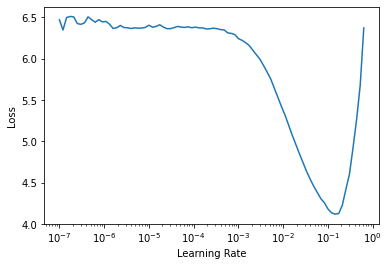

In [10]:
learn = cnn_learner(dls, MODELO, metrics=[error_rate, accuracy])
learn.lr_find()

# experiments with fastai

## first unfreeze and train

The fisrt thing I want to test is what happens if since the first moment I unfreeze all and train.

In [11]:
learn = cnn_learner(dls, MODELO, metrics=[error_rate, accuracy])
learn.unfreeze()
learn.print_trainable_count()
learn.fit(MIN_EPOCHS*2,lr=0.01)

Trainable 11,756,096, not trainable 0. Total params: 11,756,096


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,6.211913,5980.273926,0.990186,0.009814,00:08
1,5.971649,14.943656,0.994112,0.005888,00:07
2,5.726174,25.550959,0.967615,0.032385,00:07
3,5.431302,6.085283,0.932287,0.067713,00:07
4,5.330873,4.333529,0.946025,0.053974,00:07
5,5.247082,5.829233,0.959764,0.040236,00:07


So it seems that all the weights are trainable and they start to move because the task of the original model was not this one, so it tries to fix it moving the parameters to this new dataset, but it could not fix it in this quantity of epochs.

## normal call

Now lets see how a normal call would do

In [12]:
learn = cnn_learner(dls, MODELO, metrics=[error_rate, accuracy])
learn.print_trainable_count()
learn.fit(MIN_EPOCHS*2,lr=0.01)

Trainable 589,184, not trainable 11,166,912. Total params: 11,756,096


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.962891,4.725705,0.704612,0.295388,00:07
1,2.359264,1.308130,0.327772,0.672228,00:07
2,1.523008,0.942020,0.251227,0.748773,00:07
3,1.064294,0.957611,0.250245,0.749755,00:07
4,0.768918,0.815087,0.213935,0.786065,00:07
5,0.585575,0.865602,0.222767,0.777233,00:07


The number of trainale parameters changed by near 600k and this allowed us to train the model up to 79.7% accuracy in 6 epochs in about 44 seconds for all the classes in the new dataset.

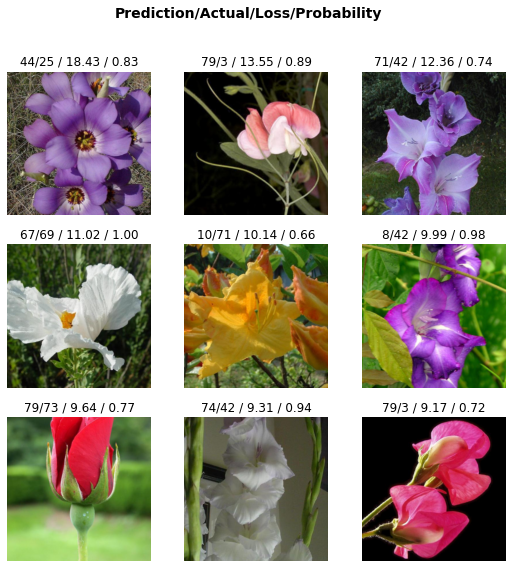

In [13]:
from fastai.interpret import *
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9)

CPU times: user 7.95 s, sys: 749 ms, total: 8.7 s
Wall time: 8.52 s


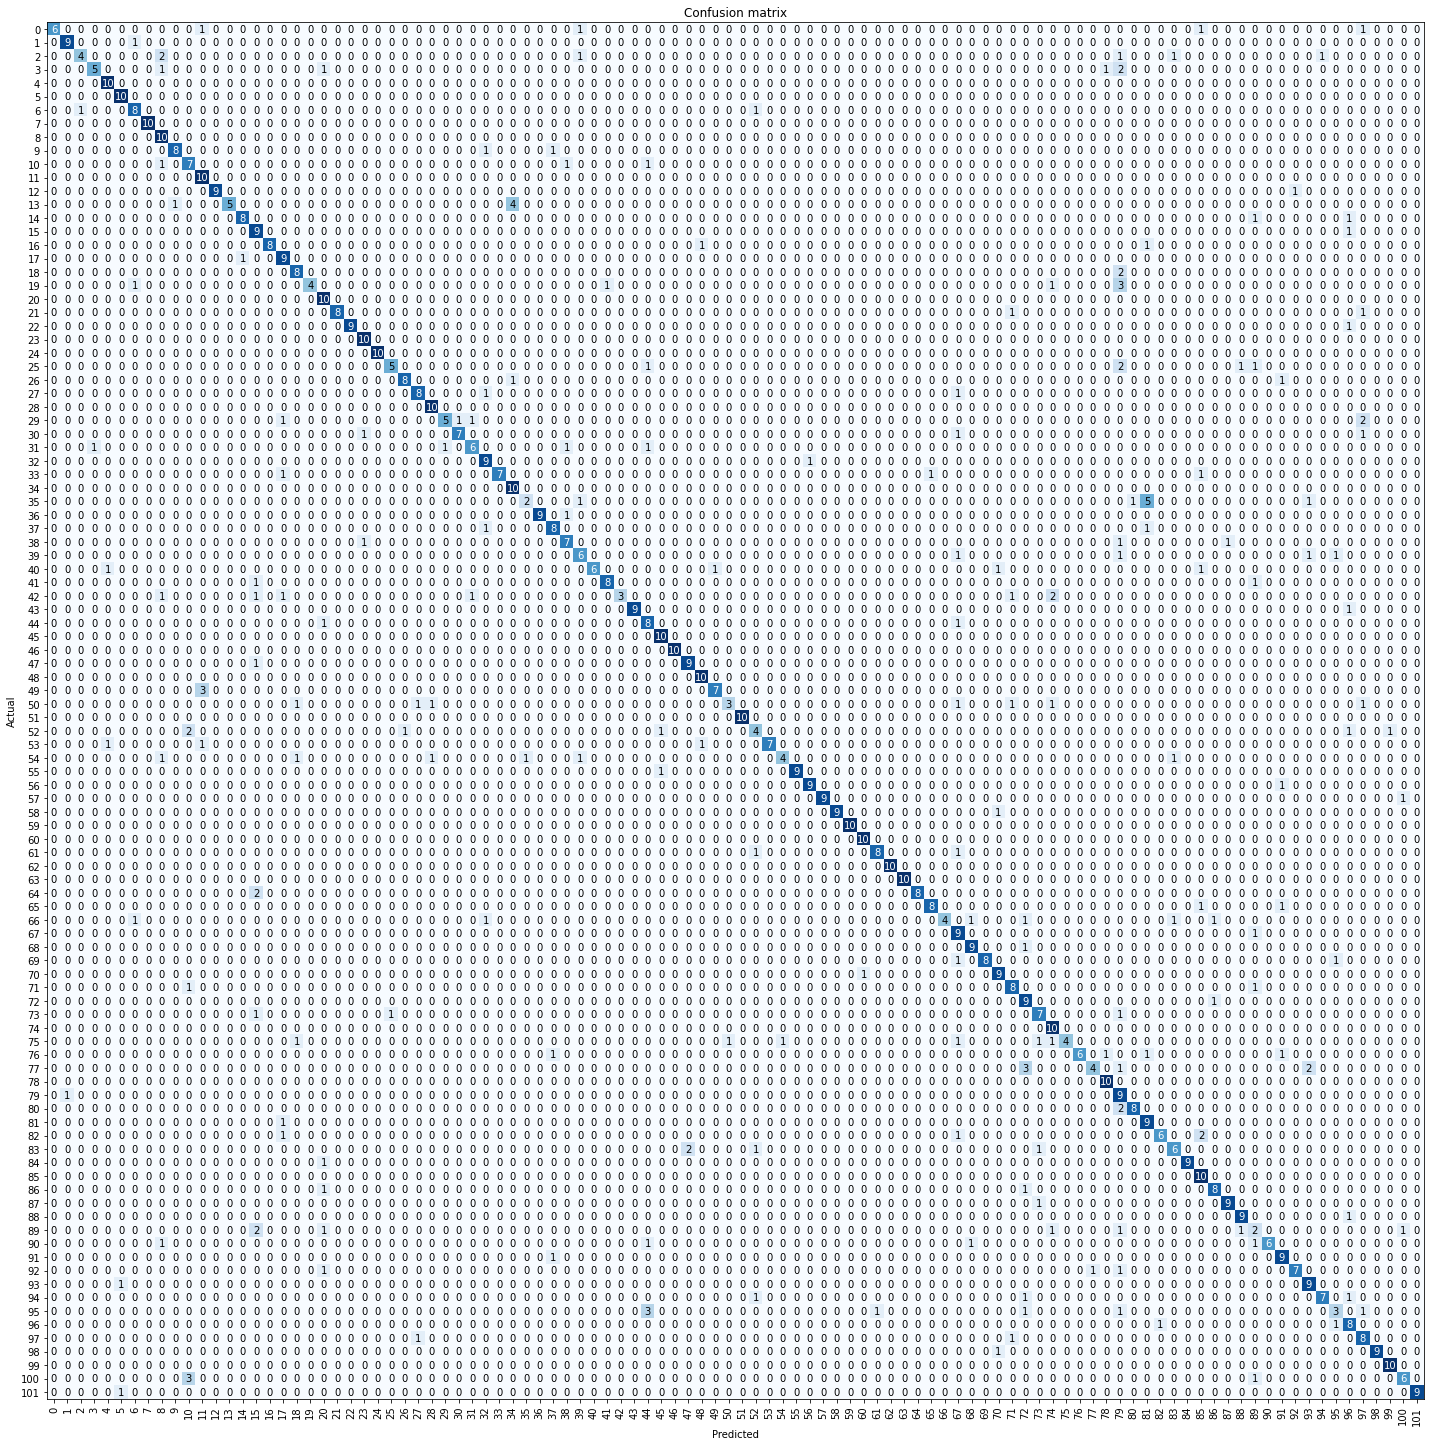

In [14]:
%%time
interp.plot_confusion_matrix(figsize=(20,20))

## freeze first, then unfreeze and freeze again

It seems that _print_shapes does have a bug in `fastai/callback/hook.py`, patch it so we use summary

In [15]:
def _print_shapes(o, bs):
    if isinstance(o, torch.Size): return ' x '.join([str(bs)] + [str(t) for t in o[1:]])
    else: return str([_print_shapes(x, bs) for x in o if hasattr(x, 'shape')])

In [16]:
learn = cnn_learner(dls, MODELO, metrics=[error_rate, accuracy])
learn.freeze_to(-1)
learn.print_trainable_count()
learn.summary()

Trainable 589,184, not trainable 11,166,912. Total params: 11,756,096


Sequential (Input shape: [])
Layer (type)         Output Shape         Param #    Trainable 
                     []                  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

So we can see which layers are not trainable and which ones are with that instruction, see that the count of parameters does match between the summary and trainable count.

In [17]:
learn.fit(MIN_EPOCHS,lr=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.716621,4.909032,0.771344,0.228656,00:07
1,2.188192,1.644273,0.375859,0.624141,00:07
2,1.480564,1.014683,0.256133,0.743867,00:07


In [18]:
learn.freeze_to(-2)
learn.print_trainable_count()
learn.fit(MIN_EPOCHS,lr=0.01)

Trainable 11,074,944, not trainable 681,152. Total params: 11,756,096


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,5.852243,1035.329468,0.977429,0.022571,00:07
1,5.106930,14.092447,0.939156,0.060844,00:07
2,4.418476,4.802925,0.787046,0.212954,00:07


In [19]:
learn.freeze_to(-3)
learn.print_trainable_count()
learn.fit(MIN_EPOCHS,lr=0.01)

Trainable 11,756,096, not trainable 0. Total params: 11,756,096


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,5.887005,6606.284180,0.990186,0.009814,00:07
1,5.350156,154.646011,0.965653,0.034347,00:07
2,4.957524,16.168621,0.875368,0.124632,00:07


This last two test are almost as bad as training all unfreezed

## Groups of the model

When fastai downloads resnet it makes a new head which is trainable which is `learn.model[1]` and the original model without the last layer is `learn.model[0]`, so we focus on `learn.model[1]`

In [20]:
learn.model[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [21]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=102, bias=False)
)

exploring the types of some layers

In [22]:
type(learn.model), type(learn.model[0]), type(learn.model[0][0]), type(learn.model[0][7]), type(learn.model[0][7][0])

(torch.nn.modules.container.Sequential,
 torch.nn.modules.container.Sequential,
 torch.nn.modules.conv.Conv2d,
 torch.nn.modules.container.Sequential,
 torchvision.models.resnet.BasicBlock)

And checking all of them are at the end a instance of `Module`

In [23]:
isinstance(learn.model, nn.Module), isinstance(learn.model[0], nn.Module), isinstance(learn.model[0][7][0], nn.Module)

(True, True, True)

## Our freeze and unfreeze

I used this "manual way" to check the number of parameters too, it happens that the number of trainable parameter by layer is less than the total we get with the function `numel` of pytorch which would be number of inputs for the tensor and not only the +1 count of `requires_grad` 

In [24]:
def set_grad(module, req_grad=False):
    for p in module.parameters():
        p.requires_grad = req_grad

def count_params(module):
    train, not_train = 0,0
    for p in module.parameters():
        if p.requires_grad:
            train += p.numel() #1
        else:
            not_train += p.numel() #1
    return train, not_train


We grab the `module` corresponding to `[0][7]` and check `requires_grad` count which is 15

In [25]:
module = learn.model[0][7]
len(params(module)), '=', len(params(module[0])), '+',len(params(module[1]))

(15, '=', 9, '+', 6)

So we train the normal way and then check the number of parameters, but also check the shapes of our convs to see their shape

In [26]:
learn.model[0][7][0].conv1.weight.shape, learn.model[0][7][1].conv1.weight.shape, 512*256*3*3 + 512*512*3*3

(torch.Size([512, 256, 3, 3]), torch.Size([512, 512, 3, 3]), 3538944)

In [27]:
learn = cnn_learner(dls, MODELO, metrics=[error_rate, accuracy])
learn.fit(MIN_EPOCHS, lr=0.01)
module = learn.model[0][7]
learn.fit(MIN_EPOCHS, lr=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,4.009228,3.705209,0.683023,0.316977,00:07
1,2.407310,1.689898,0.400393,0.599607,00:06
2,1.591860,1.038873,0.264966,0.735034,00:07


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.358869,0.867675,0.212954,0.787046,00:07
1,0.307395,0.994113,0.247301,0.752699,00:07
2,0.270139,0.884196,0.240432,0.759568,00:07


We see that the normal call it is trainning OK, then we set each param of this module to true and check how it changed the count of trainable parameters.

In [28]:
learn.print_trainable_count()
print('     Starting', count_params(module))
print('     Set all True in that module')
set_grad(module, True)
learn.print_trainable_count()
print('module', count_params(module))
learn.fit(MIN_EPOCHS*2, lr=0.01)

Trainable 589,184, not trainable 11,166,912. Total params: 11,756,096
     Starting (5120, 8388608)
     Set all True in that module


Trainable 8,977,792, not trainable 2,778,304. Total params: 11,756,096
module (8393728, 0)


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,4.505842,96.872154,0.972522,0.027478,00:07
1,3.496177,5.242794,0.710500,0.289500,00:07
2,2.814449,2.109637,0.508341,0.491658,00:07
3,2.248096,1.868002,0.446516,0.553484,00:07
4,1.785474,2.151374,0.449460,0.550540,00:07
5,1.479228,1.958117,0.412169,0.587831,00:07


It went up by 8 million And as expected it does have a bad inpact on performance, lets just check what happens with `[0][0]`

In [29]:
learn = cnn_learner(dls, MODELO, metrics=[error_rate, accuracy])
module = learn.model[0][0]
learn.print_trainable_count()
set_grad(module, True)
learn.print_trainable_count()
learn.fit(MIN_EPOCHS*2, lr=0.01)

Trainable 589,184, not trainable 11,166,912. Total params: 11,756,096


Trainable 598,592, not trainable 11,157,504. Total params: 11,756,096


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,4.833165,6.795529,0.875368,0.124632,00:08
1,3.483630,3.097856,0.650638,0.349362,00:08
2,2.583438,2.028450,0.490677,0.509323,00:08
3,1.942188,1.832129,0.418057,0.581943,00:08
4,1.510515,1.638295,0.371933,0.628067,00:08
5,1.227913,1.727606,0.406281,0.593719,00:08


Lets try fit_one_cycle

In [30]:
learn = cnn_learner(dls, MODELO, metrics=[error_rate, accuracy])
learn.freeze_to(1)
learn.fit_one_cycle(MIN_EPOCHS*2, lr_max=1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,6.135869,3.715233,0.805692,0.194308,00:08
1,4.076013,1.722756,0.404318,0.595682,00:08
2,2.738077,1.113370,0.228656,0.771344,00:08
3,1.885557,0.813592,0.166830,0.833170,00:08
4,1.333767,0.735053,0.152110,0.847890,00:08
5,0.974479,0.727847,0.145240,0.854760,00:08


Then unfreeze and train a little more first finding suguested lr

Trainable 11,756,096, not trainable 0. Total params: 11,756,096


SuggestedLRs(lr_min=0.00014454397605732084, lr_steep=6.309573450380412e-07)

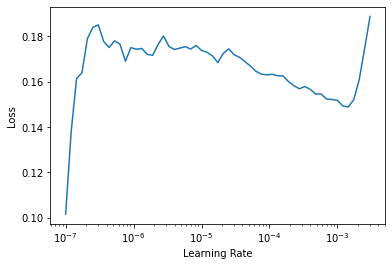

In [31]:
learn.unfreeze()
learn.print_trainable_count()
learn.lr_find(suggestions=True)

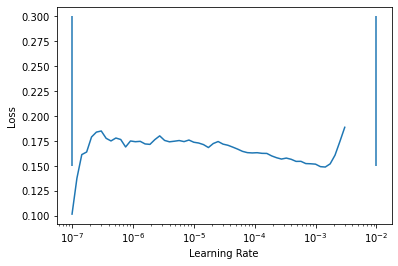

In [32]:
learn.recorder.plot_lr_find()
plt.vlines(1e-7, 0.15, 0.3)
plt.vlines(1e-2, 0.15, 0.3)

In [33]:
learn.fit_one_cycle(MIN_EPOCHS*2, lr_max=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.173850,0.688247,0.144259,0.855741,00:08
1,0.151228,0.709930,0.162905,0.837095,00:08
2,0.131801,0.685461,0.157017,0.842983,00:08
3,0.108077,0.594113,0.136408,0.863592,00:08
4,0.088094,0.574240,0.140334,0.859666,00:08
5,0.071867,0.557920,0.133464,0.866536,00:08


It seems that it trained OK, so lets continue and see what happens

In [34]:
learn.print_trainable_count()
learn.fit_one_cycle(MIN_EPOCHS*2, lr_max=slice(1e-4, 1e-3))

Trainable 11,756,096, not trainable 0. Total params: 11,756,096


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.026176,0.524478,0.134446,0.865554,00:08
1,0.024268,0.505036,0.119725,0.880275,00:08
2,0.022492,0.518885,0.124632,0.875368,00:08
3,0.020477,0.494323,0.119725,0.880275,00:08
4,0.016893,0.483734,0.113837,0.886163,00:08
5,0.014929,0.484131,0.120707,0.879293,00:08


In [35]:
learn.print_trainable_count()
learn.fit_one_cycle(MIN_EPOCHS*2, lr_max=slice(1e-4, 1e-3))

Trainable 11,756,096, not trainable 0. Total params: 11,756,096


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.008589,0.470198,0.116781,0.883219,00:08
1,0.007291,0.453335,0.116781,0.883219,00:08
2,0.006617,0.447306,0.100098,0.899902,00:08
3,0.005802,0.439279,0.100098,0.899902,00:08
4,0.005128,0.434170,0.105986,0.894014,00:08
5,0.005428,0.433756,0.105005,0.894995,00:08


Is still training OK.

In [36]:
learn.print_trainable_count()
learn.fit_one_cycle(MIN_EPOCHS*2, lr_max=slice(1e-4, 1e-3))

Trainable 11,756,096, not trainable 0. Total params: 11,756,096


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.004525,0.419260,0.099117,0.900883,00:08
1,0.004040,0.430655,0.106968,0.893032,00:08
2,0.028875,0.682514,0.180569,0.819431,00:08
3,0.041968,0.777513,0.200196,0.799804,00:09
4,0.037666,0.606697,0.154073,0.845927,00:08
5,0.031700,0.551815,0.144259,0.855741,00:08


So it trained correctly up to this point, but we should use fit_one_cycle to not scramble the weights

In [37]:
learn.print_trainable_count()
learn.fit(MIN_EPOCHS*2, lr=slice(1e-4, 1e-3))

Trainable 11,756,096, not trainable 0. Total params: 11,756,096


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.014037,0.578475,0.139352,0.860648,00:08
1,0.018503,0.559318,0.145240,0.854760,00:08
2,0.022501,0.626959,0.152110,0.847890,00:08
3,0.023967,0.612000,0.148184,0.851816,00:08
4,0.026646,0.661155,0.168793,0.831207,00:09
5,0.029120,0.709298,0.182532,0.817468,00:09


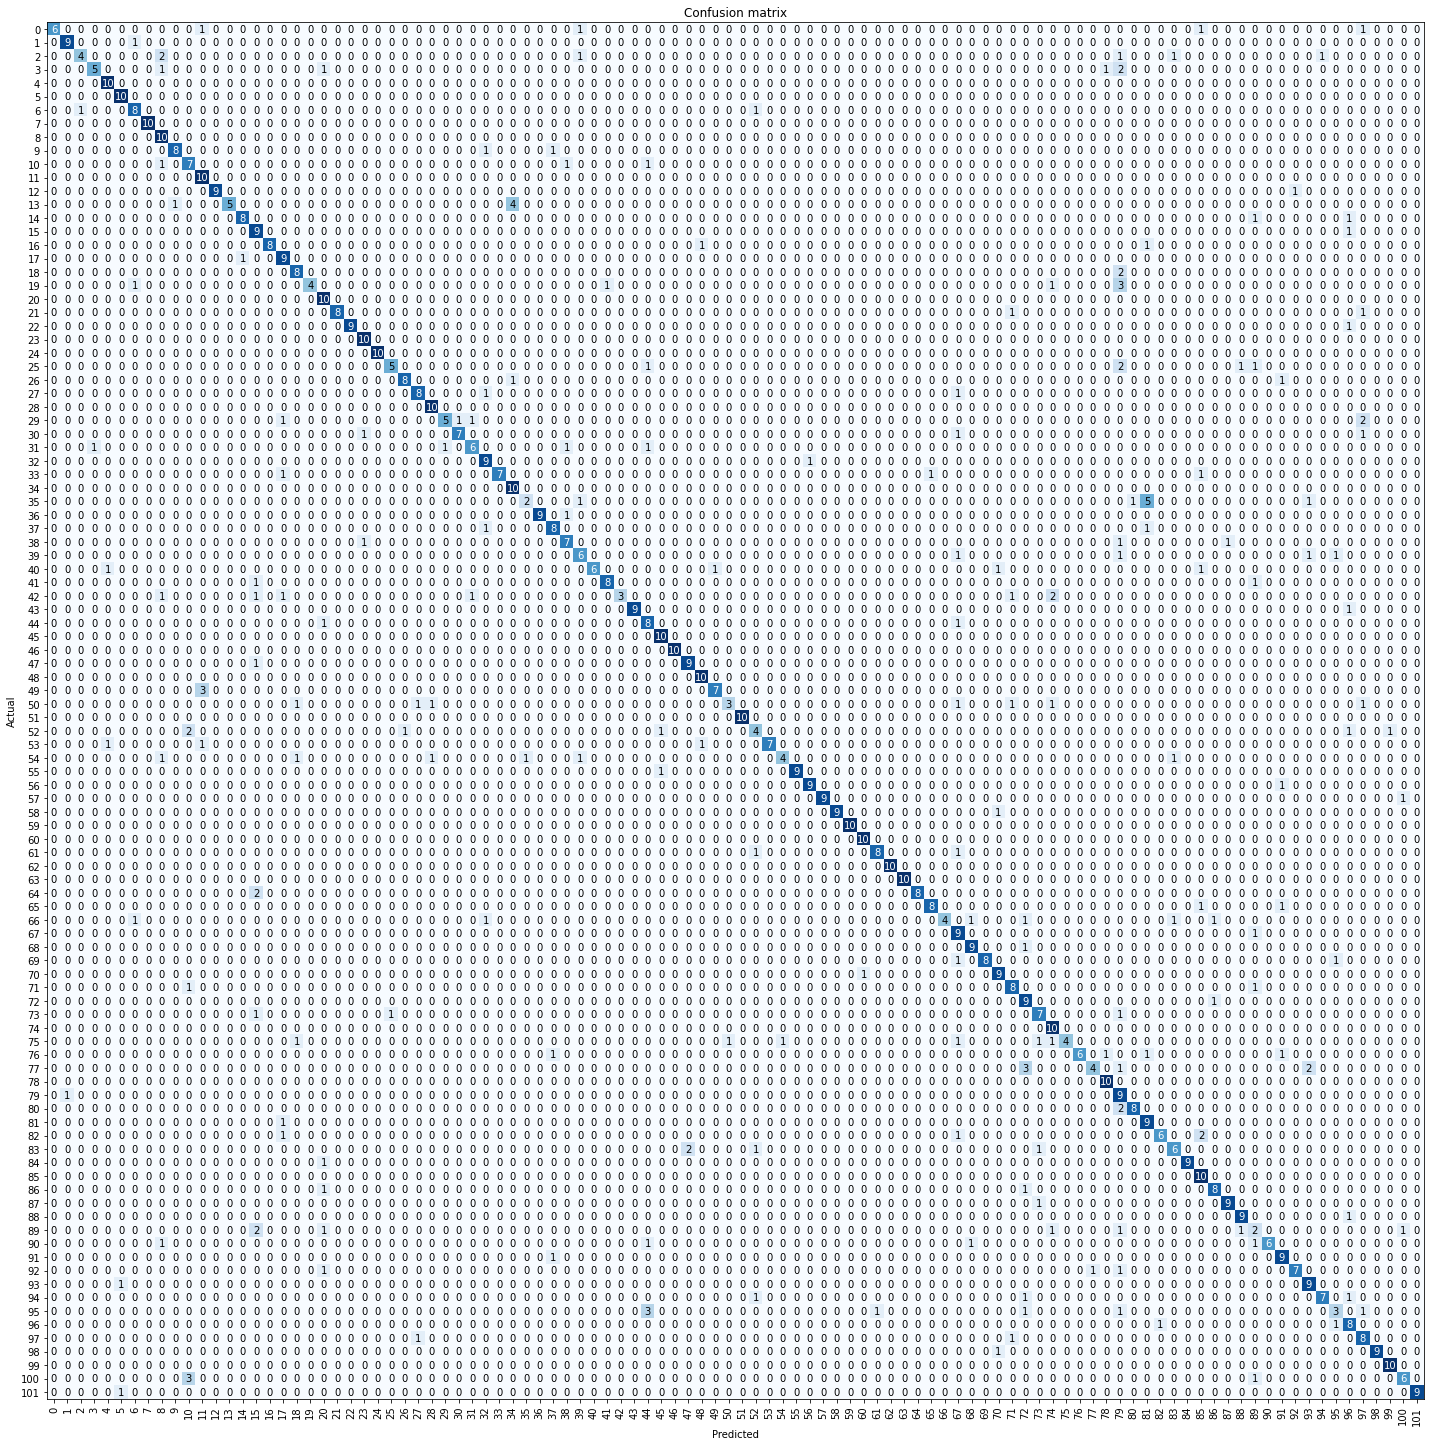

In [38]:
interp.plot_confusion_matrix(figsize=(20,20))

## Lets try again unfreeze [0][0]

So lets check again if that is correct?

In [39]:
learn = cnn_learner(dls, MODELO, metrics=[error_rate, accuracy])
learn.print_trainable_count()
module = learn.model[0][0]
module

Trainable 589,184, not trainable 11,166,912. Total params: 11,756,096


Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

And train normally

In [40]:
learn.fit(MIN_EPOCHS, lr=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.761392,3.705355,0.660451,0.339549,00:10
1,2.260533,1.299810,0.334642,0.665358,00:09
2,1.515022,1.018934,0.261040,0.738960,00:09


In [41]:
learn.print_trainable_count()
set_grad(module, True)
learn.print_trainable_count()
learn.fit(4, lr=0.01)

Trainable 589,184, not trainable 11,166,912. Total params: 11,756,096


Trainable 598,592, not trainable 11,157,504. Total params: 11,756,096


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.355885,3.065686,0.575074,0.424926,00:10
1,1.030266,1.810934,0.386654,0.613346,00:09
2,0.861590,1.402364,0.300294,0.699706,00:10
3,0.715286,1.249259,0.286555,0.713445,00:09


The trainable count went up by 9k and it is trainning, let see the summary

In [42]:
learn.summary()

Sequential (Input shape: [])
Layer (type)         Output Shape         Param #    Trainable 
                     []                  
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

In [43]:
learn.freeze_to(-1)
learn.print_trainable_count()
learn.summary()

Trainable 589,184, not trainable 11,166,912. Total params: 11,756,096


Sequential (Input shape: [])
Layer (type)         Output Shape         Param #    Trainable 
                     []                  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

In [44]:
learn.fit(MIN_EPOCHS, lr=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.758219,2.438539,0.461237,0.538764,00:08
1,0.686305,1.519667,0.314033,0.685967,00:08
2,0.594004,1.234982,0.268891,0.731109,00:09


Lets train a little more like this

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=9.12010818865383e-07)

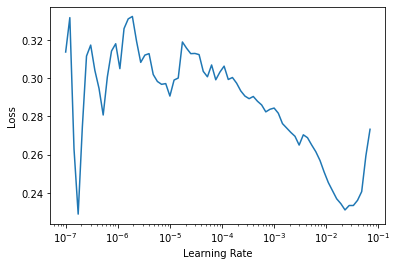

In [45]:
learn.lr_find(suggestions=True)

In [46]:
learn.fit(MIN_EPOCHS*3, lr=2e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.321956,0.903649,0.209028,0.790972,00:08
1,0.220126,0.803184,0.198234,0.801766,00:08
2,0.174543,0.755238,0.191364,0.808636,00:08
3,0.135911,0.742859,0.193327,0.806673,00:08
4,0.108346,0.732895,0.181551,0.818449,00:08
5,0.093033,0.718910,0.175662,0.824338,00:08
6,0.081346,0.716996,0.173700,0.826300,00:08
7,0.072279,0.703890,0.164868,0.835132,00:08
8,0.060487,0.704482,0.167812,0.832188,00:08


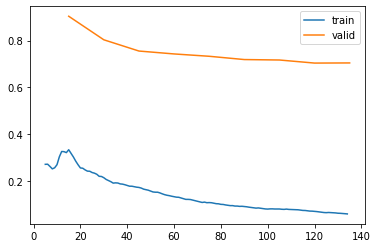

In [47]:
learn.recorder.plot_loss()

It seems that validation loss is starting to go up

SuggestedLRs(lr_min=2.7542287170945203e-07, lr_steep=7.585775847473997e-07)

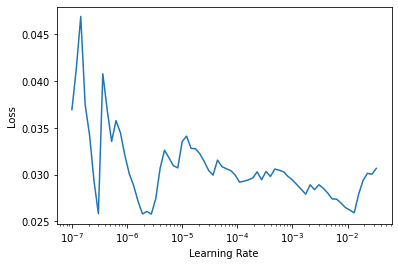

In [48]:
learn.lr_find(suggestions=True)

In [49]:
learn.fit(MIN_EPOCHS*10, lr=6.92e-7)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.033165,0.704382,0.163886,0.836114,00:08
1,0.030819,0.702037,0.160942,0.839058,00:08
2,0.034960,0.699020,0.162905,0.837095,00:08
3,0.032294,0.700194,0.159961,0.840039,00:08
4,0.034028,0.699347,0.163886,0.836114,00:08
5,0.034322,0.698568,0.162905,0.837095,00:08
6,0.034666,0.696233,0.163886,0.836114,00:08
7,0.033148,0.698696,0.157998,0.842002,00:08
8,0.035211,0.697572,0.161923,0.838077,00:08
9,0.036685,0.704919,0.160942,0.839058,00:08


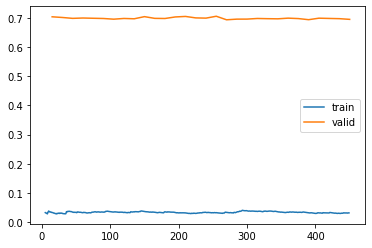

In [50]:
learn.recorder.plot_loss()

So there is no more learning, it mostly got stuck on learning

## creating a different head

We can check the code of a function if we imported fastai appending `??` to see the effect of each parameter

In [51]:
create_head??

In [52]:
head2 = create_head(512, 102, concat_pool=False, lin_first=True)
learn = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy], custom_head=head2)
learn.fit(7, lr=0.01)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,4.146598,4.654510,0.803729,0.196271,00:07
1,2.790039,1.600513,0.398430,0.601570,00:07
2,2.020180,1.319931,0.342493,0.657507,00:06
3,1.546340,0.792073,0.222767,0.777233,00:07
4,1.204596,0.946119,0.235525,0.764475,00:08
5,0.969453,0.844426,0.228656,0.771344,00:07
6,0.801591,0.743568,0.195289,0.804711,00:08


## Replacing last layer of original model

The way fastai hangles transfer learning is with groups of layers, the head is the last one, but I have taked a look at pytorch example and they use is only a single `Linear` layer as head. This can be done as simple as this

In [53]:
original_r18 = resnet18(true)

######### NOTE: requires_grad = False for all parameters
for param in original_r18.parameters():
    param.requires_grad = False

######### NOTE: so only the last Linear layer will be updated on backpropagation
num_ftrs = original_r18.fc.in_features
original_r18.fc = nn.Linear(num_ftrs, 102)

original_r18 = original_r18.to(torch.device('cuda'))
learn = Learner(dls, original_r18, metrics=[error_rate, accuracy])
learn.print_trainable_count()
learn.fit(MIN_EPOCHS*3, lr=0.01)

Trainable 52,326, not trainable 11,176,512. Total params: 11,228,838


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,6.401901,4.308004,0.738960,0.261040,00:06
1,4.179393,2.134671,0.456330,0.543670,00:06
2,2.775817,1.220535,0.280667,0.719333,00:06
3,1.927715,1.062615,0.261040,0.738960,00:06
4,1.369807,0.762000,0.171737,0.828263,00:06
5,0.981681,0.701764,0.166830,0.833170,00:06
6,0.718842,0.684875,0.167812,0.832188,00:06
7,0.533579,0.645837,0.154073,0.845927,00:06
8,0.399378,0.614915,0.149166,0.850834,00:06


# pytorch example adapted data

SO I think the only missing thins is to look at how this was donde in original pytorch, which I did at end.

I copy and paste their code and adapt it for the training data because they use `hymenoptera_data.zip` which haves the structure of `train/labels/images`and `val/labels/images` so lets make som extra steps to match that "shape"

In [54]:
newp = untar_data('https://download.pytorch.org/tutorial/hymenoptera_data.zip');(newp).ls()

(#2) [Path('/home/tyoc213/.fastai/data/hymenoptera_data/val'),Path('/home/tyoc213/.fastai/data/hymenoptera_data/train')]

Pytorch data loading requires the structure of parent subfolders for training and validation datasets and inside each one a subfolder for the label, which inside contains the different images. All of that constructed with this:

In [55]:
import os
import shutil

# create all label directories for train and val
for l in dls.vocab:
    os.makedirs(path/f'train/{l}', exist_ok=True)
    os.makedirs(path/f'val/{l}', exist_ok=True)

# copy files to target location
for idx, i in enumerate(df.iloc):
    imgp = path/i.img
    name = imgp.name.replace('jpg/', '')
    final = path/f'val/{i.label}/{name}' if i.is_valid else path/f'train/{i.label}/{name}'
    shutil.copyfile(imgp, final)
#     if idx % 100 == 0: print('copied', idx)

Now we can use the same `path` we used for fastai

In [56]:
newp = path

And here is the pytorch sample running

In [57]:
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import copy

###########################################################

model_conv = torchvision.models.resnet18(pretrained=True)

######### NOTE: requires_grad = False for all parameters
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
######### NOTE: so only the last Linear layer will be updated on backpropagation
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 102) ######### NOTE: adjust to 102 the otput, if not: RuntimeError: CUDA error: device-side assert triggered

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

###########################################################

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 102) ######### NOTE: adjust to 102 the otput, if not: RuntimeError: CUDA error: device-side assert triggered

###########################################################

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    device = torch.device("cuda") #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model





data_dir = newp
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print('train model_ft')
model_ft = train_model(model_ft, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

print('\n\ntrain model_conv')
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

train model_ft
Epoch 0/24
----------
train Loss: 4.7651 Acc: 0.0137
val Loss: 4.8367 Acc: 0.0157

Epoch 1/24
----------
train Loss: 4.7715 Acc: 0.0108
val Loss: 4.8290 Acc: 0.0137

Epoch 2/24
----------
train Loss: 4.7722 Acc: 0.0128
val Loss: 4.8244 Acc: 0.0157

Epoch 3/24
----------
train Loss: 4.7745 Acc: 0.0098
val Loss: 4.8190 Acc: 0.0147

Epoch 4/24
----------
train Loss: 4.7645 Acc: 0.0147
val Loss: 4.8311 Acc: 0.0128

Epoch 5/24
----------
train Loss: 4.7694 Acc: 0.0137
val Loss: 4.8203 Acc: 0.0157

Epoch 6/24
----------
train Loss: 4.7601 Acc: 0.0186
val Loss: 4.8365 Acc: 0.0147

Epoch 7/24
----------
train Loss: 4.7845 Acc: 0.0118
val Loss: 4.8189 Acc: 0.0147

Epoch 8/24
----------
train Loss: 4.7727 Acc: 0.0157
val Loss: 4.8300 Acc: 0.0137

Epoch 9/24
----------
train Loss: 4.7661 Acc: 0.0147
val Loss: 4.8286 Acc: 0.0177

Epoch 10/24
----------
train Loss: 4.7721 Acc: 0.0118
val Loss: 4.8228 Acc: 0.0157

Epoch 11/24
----------
train Loss: 4.7713 Acc: 0.0128
val Loss: 4.8293 

As we see, eventhought the model is also training with transfer learning, it is going up more slowly, this is the effect on how the head is constructed, also model_ft is trainning more slow than model_conv.

# Conclusion

Using transfer learning indeed does help training a fine tuned sub-task for that model replacing his head, there are some heads that works best than others depending on the task but the initial trainning time that you get from the pretrained model base weights is helpfull in this case only needing some minutes to train with good accuracy for a new set of target images.

So freezing the last models help retargeting the rest of the model to the new task, and the discriminative learning rates when all the model is unfreezed helps in not moving all the weigts of the model at the same speed leting it adapt more tearsely.

If you start with the pretrained model and unfreeze it all, in some steps the accuracy is lost it doesnt matter that you freeze again up to last layer that means the backpropagation adjusting for the new task has messed up pretrained weights. That is why you need to freeze only the last layers but being cautions of not changing the body weights to much at the end.

Watching the loss for training and validation indeed help to see if the model is still training or not.